In [ ]:
!pip install -r requirements.txt

In [1]:
import io
import json

import requests
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from robustbench import load_model
from captum.attr import LayerGradCam, LayerAttribution, visualization

In [22]:
def download_image(url):
    r = requests.get(url)
    image = Image.open(io.BytesIO(r.content))
    return image

@torch.no_grad()
def predict(model, image):
    logits = model(image.unsqueeze(dim=0))
    y_pred = logits.argmax(dim=-1)
    idx = int(y_pred)
    cls = idx2cls[idx]
    score = float(logits.softmax(dim=-1)[:, y_pred] * 100)
    print("Class: {} | Score: {:.2f}% | Index: {}".format(cls, score, idx))
    return idx, cls, score, logits

def attribute(method, image, clsidx, image_size=(224, 224)):
    attr = method.attribute(image, target=clsidx)
    attr = LayerAttribution.interpolate(attr, image_size)
    attr = attr.cpu().detach().squeeze(dim=0).permute(1, 2, 0).numpy()
    return attr

def visualize(attr, image):
    return visualization.visualize_image_attr(
        attr,
        np.array(image.resize((224, 224))),
        method="blended_heat_map",
        sign="absolute_value",
        show_colorbar=True
    ) 

## ImageNet Experiments

Here we compare GradCAM attributions for a vanilla ResNet-50 trained on ImageNet and a robustly trained ResNet-50 trained on ImageNet against the Linf threat model from the paper ["Do Adversarially Robust ImageNet Models Transfer Better", Salman et al. (2020)](https://arxiv.org/abs/2007.08489)

In [ ]:
!wget -O data/imagenet_class_index.json https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json imagenet_class_index.json

In [87]:
# Load imagenet class mapping
with open("data/imagenet_class_index.json") as f:
    idx2cls = json.load(f)
    idx2cls = {int(k): v[-1] for k, v in idx2cls.items()}
    cls2idx = {v: k for k, v in idx2cls.items()}

# Load models
threat_model = "Linf"
resnet = load_model(model_name="Standard_R50", dataset="imagenet")
resnet_robust = load_model(model_name="Salman2020Do_R50", dataset="imagenet", threat_model=threat_model)
resnet = resnet.eval()
resnet_robust = resnet_robust.eval()

# GradCAM operates on the last conv layer
gc = LayerGradCam(resnet, resnet.model.layer4[-1].conv3)
gc_robust = LayerGradCam(resnet_robust, resnet_robust.model.layer4[-1].conv3)

# preprocessing
transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
])

#### Sample Image: Goose

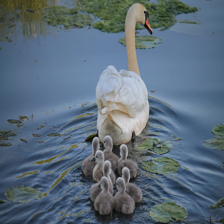

ResNet Result:
Class: goose | Score: 73.13% | Index: 99
Robust ResNet Result:
Class: goose | Score: 67.79% | Index: 99


In [89]:
url = "https://github.com/pytorch/captum/raw/master/tutorials/img/resnet/swan-3299528_1280.jpg"
cls = "goose"
image = download_image(url)
image.resize((224, 224)).show()

print("ResNet Result:")
_ = predict(resnet, transforms(image))
print("Robust ResNet Result:")
_ = predict(resnet_robust, transforms(image))

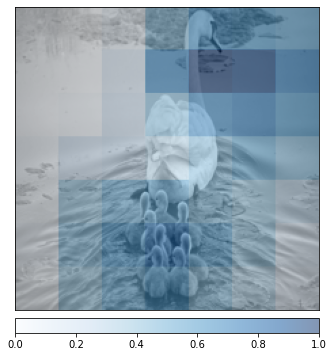

In [90]:
attr = attribute(gc, transforms(image), clsidx=cls2idx[cls])
_ = visualize(attr, image)

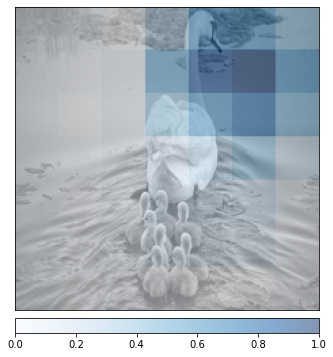

In [91]:
attr = attribute(gc_robust, transforms(image), clsidx=cls2idx[cls])
_ = visualize(attr, image)

#### Sample Image: Hammerhead

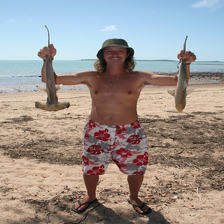

ResNet Result:
Class: swimming_trunks | Score: 57.32% | Index: 842
Robust ResNet Result:
Class: swimming_trunks | Score: 46.23% | Index: 842


In [97]:
url = "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01494475_hammerhead.JPEG"
cls = "hammerhead"
image = download_image(url)
image.resize((224, 224)).show()

print("ResNet Result:")
_ = predict(resnet, transforms(image))
print("Robust ResNet Result:")
_ = predict(resnet_robust, transforms(image))

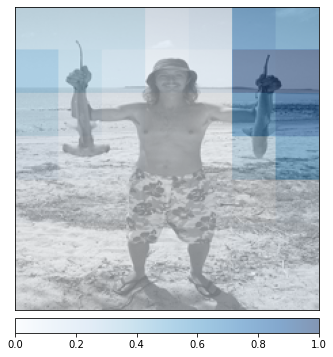

In [98]:
attr = attribute(gc, transforms(image), clsidx=cls2idx[cls])
_ = visualize(attr, image)

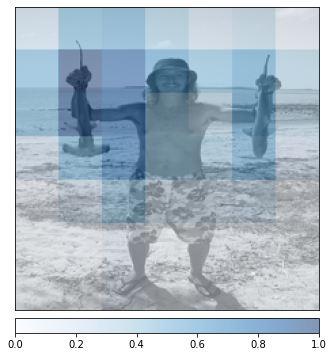

In [99]:
attr = attribute(gc_robust, transforms(image), clsidx=cls2idx[cls])
_ = visualize(attr, image)

#### Sample Image: Theater Curtain

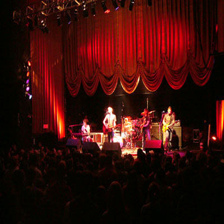

ResNet Result:
Class: theater_curtain | Score: 99.88% | Index: 854
Robust ResNet Result:
Class: theater_curtain | Score: 98.42% | Index: 854


In [100]:
url = "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n04418357_theater_curtain.JPEG"
cls = "theater_curtain"
image = download_image(url)
image.resize((224, 224)).show()

print("ResNet Result:")
_ = predict(resnet, transforms(image))
print("Robust ResNet Result:")
_ = predict(resnet_robust, transforms(image))

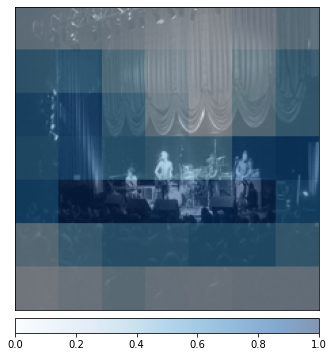

In [105]:
attr = attribute(gc, transforms(image), clsidx=cls2idx[cls])
_ = visualize(attr, image)

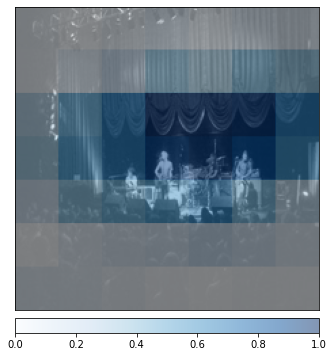

In [102]:
attr = attribute(gc_robust, transforms(image), clsidx=cls2idx[cls])
_ = visualize(attr, image)

#### Analysis

Images containing multiple objects were sampled as an attempt to avoid the explainable method from just centering attributes around a single object. In the case of the goose and hammerhead images, GradCAM attributes for the robustly trained model appear to hone in on the object of interest whereas the vanilla model simply highlights large portions of the image. For the theater curtain sample, both models appear to highlight the band instead of the actual theater curtain. For this small sample size, GradCAM appears to perform better for robustly trained models compared to non-robustly trained ImageNet trained models.

## Bonus: RESISC45 Experiments

In these experiments we train ResNet-50 and ConvNeXt Base models on the REmote Sensing Image Scene Classification (RESISC45) dataset and compare the GradCAM attributions. We use the TorchGeo library and PyTorch Lightning to train the models which both achieve 90% and 91% overall acurracy, respectively.

In [6]:
from torchgeo.datasets import RESISC45

from src.modules import RESISC45ClassificationTask

to_pil = T.ToPILImage()

In [47]:
# Load dataset test set and class mapping
dataset = RESISC45(root="data/", split="test")
idx2cls = {i: c for i, c in enumerate(dataset.classes)}
cls2idx = {v: k for k, v in idx2cls.items()}

# Load models
path = "logs/resisc45-resnet/model.ckpt"
resnet = RESISC45ClassificationTask.load_from_checkpoint(path).model
resnet.eval()
path = "logs/resisc45-convnext/model.ckpt"
convnext = RESISC45ClassificationTask.load_from_checkpoint(path).model
convnext.eval()

# GradCAM operates on the last conv layer
gc_resnet = LayerGradCam(resnet, resnet.layer4[-1].conv3)
gc_convnext = LayerGradCam(convnext, convnext.features[-1][-1].block[0])

# Preprocessing
MEAN = [0.36801773, 0.38097873, 0.343583]
STD = [0.14540215, 0.13558227, 0.13203649]

transforms = T.Compose([
    T.Resize((224, 224), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(
        mean=MEAN,
        std=STD
    )
])

#### Sample Image: Airplane

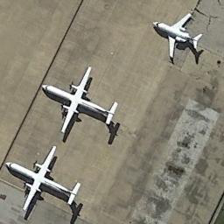

True Label: airplane

ResNet Result:
Class: airplane | Score: 100.00% | Index: 0

ConvNeXt Result:
Class: airplane | Score: 100.00% | Index: 0


In [48]:
idx = 0
sample = dataset[idx]
image, label = sample["image"], sample["label"]
image = to_pil(image)
cls = dataset.classes[int(label)]

image.resize((224, 224)).show()

print(f"True Label: {cls}")
print("\nResNet Result:")
_ = predict(resnet, transforms(image))
print("\nConvNeXt Result:")
_ = predict(convnext, transforms(image))

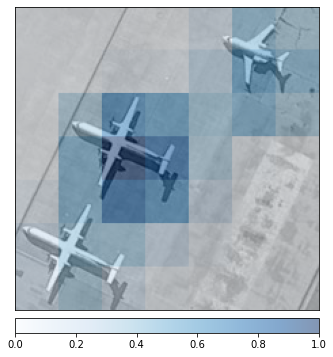

In [49]:
attr = attribute(gc_resnet, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

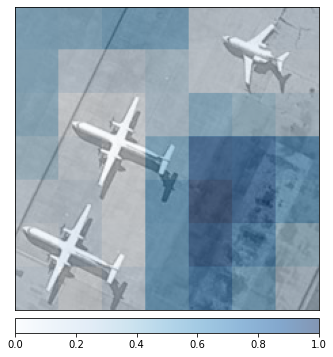

In [50]:
attr = attribute(gc_convnext, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

#### Sample Image: Church

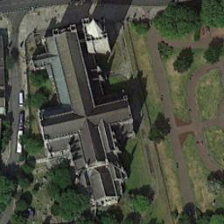

True Label: church

ResNet Result:
Class: palace | Score: 81.07% | Index: 27

ConvNeXt Result:
Class: church | Score: 58.37% | Index: 7


In [51]:
idx = 1000
sample = dataset[idx]
image, label = sample["image"], sample["label"]
image = to_pil(image)
cls = dataset.classes[int(label)]

image.resize((224, 224)).show()

print(f"True Label: {cls}")
print("\nResNet Result:")
_ = predict(resnet, transforms(image))
print("\nConvNeXt Result:")
_ = predict(convnext, transforms(image))

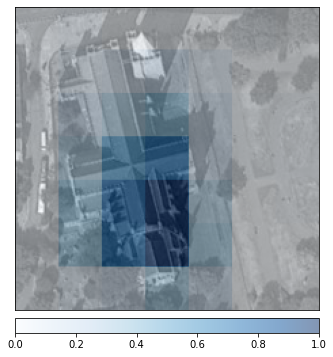

In [52]:
attr = attribute(gc_resnet, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

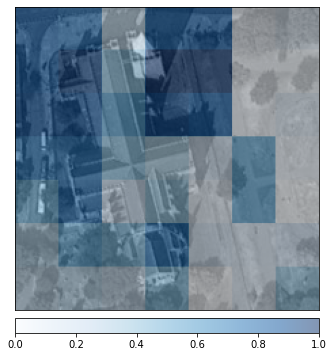

In [53]:
attr = attribute(gc_convnext, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

#### Sample Image: Intersection

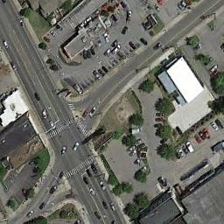

True Label: intersection

ResNet Result:
Class: intersection | Score: 97.73% | Index: 19

ConvNeXt Result:
Class: intersection | Score: 99.94% | Index: 19


In [54]:
idx = 2700
sample = dataset[idx]
image, label = sample["image"], sample["label"]
image = to_pil(image)
cls = dataset.classes[int(label)]

image.resize((224, 224)).show()

print(f"True Label: {cls}")
print("\nResNet Result:")
_ = predict(resnet, transforms(image))
print("\nConvNeXt Result:")
_ = predict(convnext, transforms(image))

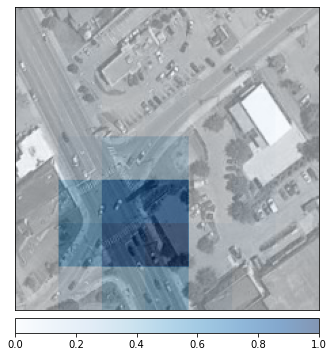

In [55]:
attr = attribute(gc_resnet, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

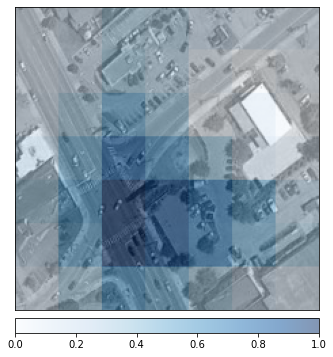

In [56]:
attr = attribute(gc_convnext, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

#### Sample Image: Medium Residential

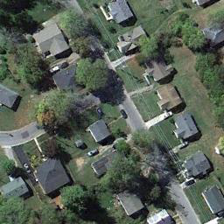

True Label: medium_residential

ResNet Result:
Class: medium_residential | Score: 98.77% | Index: 23

ConvNeXt Result:
Class: medium_residential | Score: 99.96% | Index: 23


In [58]:
idx = 3300
sample = dataset[idx]
image, label = sample["image"], sample["label"]
image = to_pil(image)
cls = dataset.classes[int(label)]

image.resize((224, 224)).show()

print(f"True Label: {cls}")
print("\nResNet Result:")
_ = predict(resnet, transforms(image))
print("\nConvNeXt Result:")
_ = predict(convnext, transforms(image))

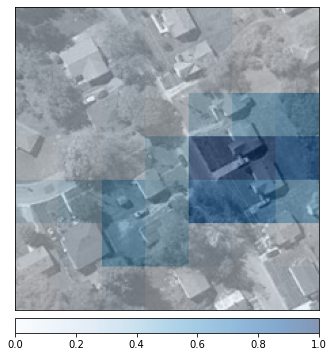

In [59]:
attr = attribute(gc_resnet, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

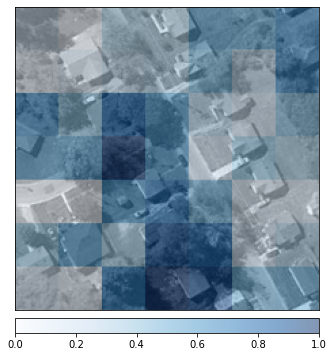

In [60]:
attr = attribute(gc_convnext, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

#### Sample Image: Overpass

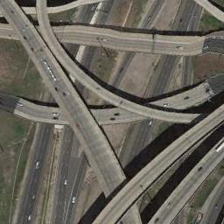

True Label: overpass

ResNet Result:
Class: overpass | Score: 100.00% | Index: 26

ConvNeXt Result:
Class: overpass | Score: 100.00% | Index: 26


In [61]:
idx = 3700
sample = dataset[idx]
image, label = sample["image"], sample["label"]
image = to_pil(image)
cls = dataset.classes[int(label)]

image.resize((224, 224)).show()

print(f"True Label: {cls}")
print("\nResNet Result:")
_ = predict(resnet, transforms(image))
print("\nConvNeXt Result:")
_ = predict(convnext, transforms(image))

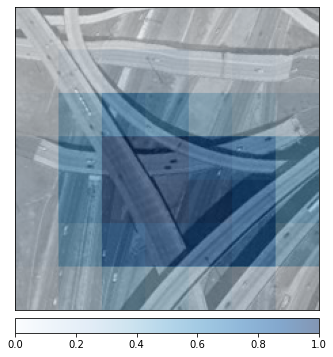

In [62]:
attr = attribute(gc_resnet, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

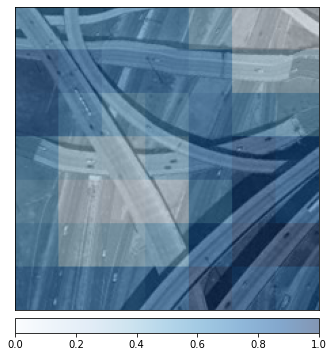

In [63]:
attr = attribute(gc_convnext, transforms(image).unsqueeze(dim=0), clsidx=cls2idx[cls])
_ = visualize(attr, image)

#### Analysis

Remotely sensed satellite imagery generally differs from ImageNet imagery in that the content within an image can be sparse or span the entire image as opposed to a central single object near the center of an image. This requires that explainable methods for satellite imagery cannot simply highlight the center of an image which would build distrust in said methods.

Notably, the ConvNeXt model generally achieves higher accuracy compared to the ResNet model. Additionally, the GradCAM attributions generated by the ResNet appear to focus on a central clustered area of an image, whereas the ConvNeXt attributions are spread across the entire image. One reason for this could be the usage of larger 7x7 convolutional kernel sizes in ConvNext compared to the typical 3x3 kernels which could lead to feature dependencies across low level feature maps.